In [2]:
import os
import sys
import re
import json
import pandas as pd 
import numpy as np
import seaborn as sns; sns.set_theme(style="whitegrid");

# import gnssrefl functions
import gnssrefl.gps as g
import gnssrefl.rinex2snr as rnx
import gnssrefl.quickLook_function as quick
import gnssrefl.gnssir as guts
import matplotlib.pyplot as plt

# We are including our repository bin to the system path so that we can import the following python modules
bin_path = os.path.abspath(os.path.join('../../bin'))
if bin_path not in sys.path:
    sys.path.append(bin_path)
    
import check_parameters 
import environment

%matplotlib inline

In [33]:
#Making sure environment variables are set
exists = environment.check_environment()
if exists == False:
    environment.set_environment()
else:
     print('environment variable ORBITS path is:\n', os.environ['ORBITS'],
          '\nenvironment variable REFL_CODE path is:\n', os.environ['REFL_CODE'],
          '\nenvironment variable EXE path is:\n', os.environ['EXE'])
        
refl_code_loc = os.environ['REFL_CODE']
# import the crx2rnx file which is dependant on your working OS - this is required to run the gnssrefl code
environment.download_crx2rnx()

environment variable ORBITS path is:
 /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits 
environment variable REFL_CODE path is:
 /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter 
environment variable EXE path is:
 /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/bin/exe
downloading CRX2RNX file
file placed in path to execubles set by EXE environment variable
finished


# Ross Ice Shelf, Antarctica

**Station Name:**  lorg

**Location:**  Lorne, Antarctica

**Archive:**  [UNAVCO](http://www.unavco.org)

**DOI:**  [https://doi.org/10.7283/ACF6-YT23](https://doi.org/10.7283/ACF6-YT23)

**Ellipsoidal Coordinates:**

- Latitude:  -78.18365
- Longitude: 170.03361
- Height:  	-7.778 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/lorg)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/LORG.sta)

[Google Maps Link](https://goo.gl/maps/bSAuLXLLMmzWqPdW9) 

<img src="https://gnss-reflections.org/static/images/LORG.jpg" width="500">



### Data Summary

Station lorg is on the Ross Ice Shelf, Antarctica.
The site is a largely featureless ice plain with no obstructions (see photo above). 
The site was installed on November 27, 2018 and decommissioned and removed on November 15, 2019. 
It recorded only GPS frequencies during its operation. 

LORG is an example station on the [GNSS-IR web app.](https://gnss-reflections.org/api?example=lorg) 

There are no significant topographic features near the station, so it is recommended to use default values 
for the elevation mask. An azimuth mask is not required.

In [4]:
%%html
<iframe src="https://gnss-reflections.org/api?example=lorg" width="1000" height="900"></iframe>

## Take a look at the Data

First make a SNR file.

In [5]:
station = 'lorg'
year = 2019 
doy = 205

lat = -78.1836
long = 170.0336
height = -7.722

In [ ]:
# Can view the parameters here
#check_parameters.rinex2snr?

In [6]:
args = check_parameters.rinex2snr(station,year,doy, translator='hybrid')
rnx.run_rinex2snr(**args)

Will seek RINEX file  lorg  year: 2019  doy: 205  translate with  hybrid
-1 / unknown........................................................................] 76077 / 76077

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2050.19.snr66




Use **quickLook** to produce a periodogram similar to the one in the web app [(For details on quickLook output)](../../docs/quickLook_desc.md). quickLook is set to use the L1 frequency by default:

minimum elevation angle (degrees) for this dataset:  0.0053


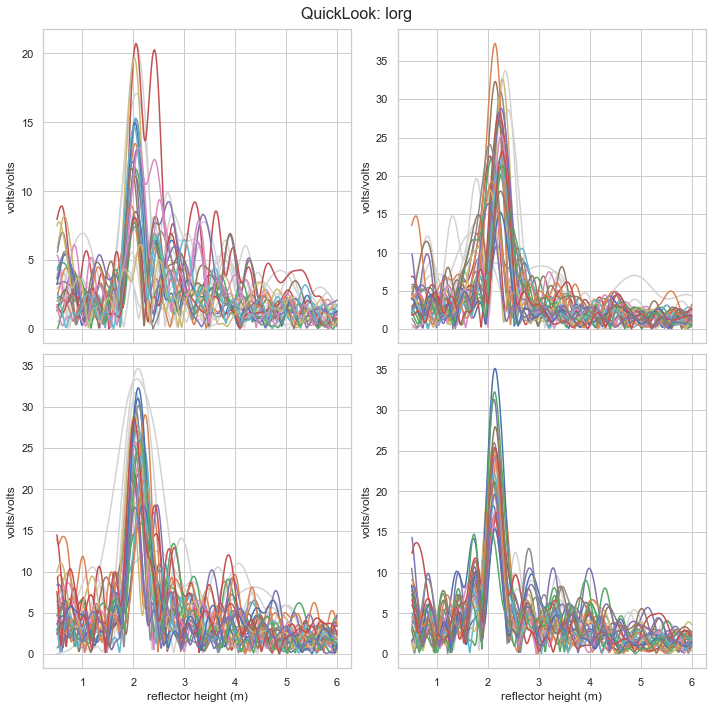

In [7]:
args = check_parameters.quicklook(station, year, doy=doy)
values, metrics = quick.quickLook_function(**args)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook: {args["station"]}', size=16)

quadrants = ['NW', 'NE', 'SW', 'SE']

for i, ax in enumerate(axes.flat):
    for fail_satellite in values[f'f{quadrants[i]}']:
        g = sns.lineplot(x=values[f'f{quadrants[i]}'][fail_satellite][0], y=values[f'f{quadrants[i]}'][fail_satellite][1], ax=ax, color='lightgrey')
    for satellite in values[quadrants[i]]:
        g = sns.lineplot(x=values[quadrants[i]][satellite][0], y=values[quadrants[i]][satellite][1], ax=ax)
    g.set_ylabel('volts/volts')
    g.set_xlabel('reflector height (m)')

plt.tight_layout()
plt.show()

Compare the periodograms for other frequencies: L2C and L5. They should be similar to the L1 periodogram, except that there
will be fewer satellite traces because only GPS satellites launched after 2005
broadcast L2C and only satellites after 2010 broadcast L5.
The northwest qudarant is the noisiest and one could certainly try to improve the results by restricting some azimuths there.
This is for L2C:

minimum elevation angle (degrees) for this dataset:  0.0053


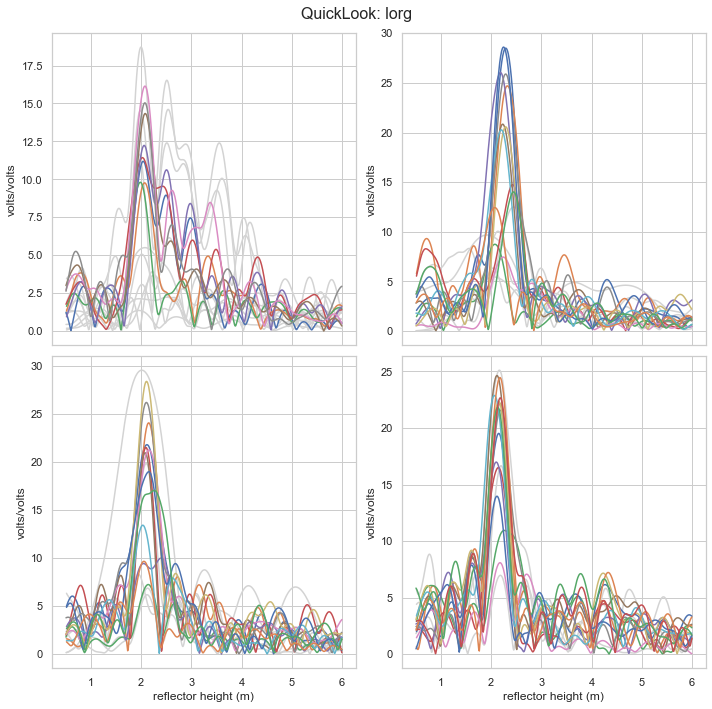

In [8]:
args = check_parameters.quicklook(station, year, doy=doy, f=20)
values, metrics = quick.quickLook_function(**args)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook: {args["station"]}', size=16)

quadrants = ['NW', 'NE', 'SW', 'SE']

for i, ax in enumerate(axes.flat):
    for fail_satellite in values[f'f{quadrants[i]}']:
        g = sns.lineplot(x=values[f'f{quadrants[i]}'][fail_satellite][0], y=values[f'f{quadrants[i]}'][fail_satellite][1], ax=ax, color='lightgrey')
    for satellite in values[quadrants[i]]:
        g = sns.lineplot(x=values[quadrants[i]][satellite][0], y=values[quadrants[i]][satellite][1], ax=ax)
    g.set_ylabel('volts/volts')
    g.set_xlabel('reflector height (m)')

plt.tight_layout()
plt.show()

This is for L5:

minimum elevation angle (degrees) for this dataset:  0.0053


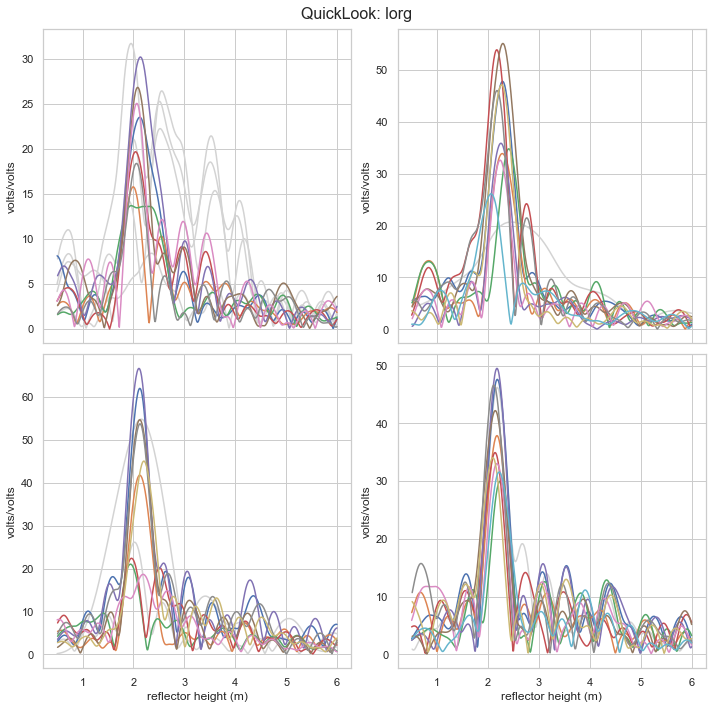

In [9]:
args = check_parameters.quicklook(station, year, doy=doy, f=5)
values, metrics = quick.quickLook_function(**args)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook: {args["station"]}', size=16)

quadrants = ['NW', 'NE', 'SW', 'SE']

for i, ax in enumerate(axes.flat):
    for fail_satellite in values[f'f{quadrants[i]}']:
        g = sns.lineplot(x=values[f'f{quadrants[i]}'][fail_satellite][0], y=values[f'f{quadrants[i]}'][fail_satellite][1], ax=ax, color='lightgrey')
    for satellite in values[quadrants[i]]:
        g = sns.lineplot(x=values[quadrants[i]][satellite][0], y=values[quadrants[i]][satellite][1], ax=ax)
    g.set_ylabel('volts/volts')
    g.set_xlabel('reflector height (m)')

plt.tight_layout()
plt.show()

### Analyze the Data
Now prepare to analyze the data using **gnssir**.  First you need to create a set of analysis instructions.
The default settings only need the station name, latitude, longitude, and ellipsoidal height.

In [ ]:
# Here we can see what parameters are available and what the defaults are:
#check_parameters.make_json?

In [10]:
# we saved the lat, long, and height earlier in the notebook
check_parameters.make_json(station, lat, long, height)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/lorg.json


In [13]:
# This is the json file that was created
json_file = f'{refl_code_loc}/input/lorg.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)

os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'lorg',
 'lat': -78.1836,
 'lon': 170.0336,
 'ht': -7.722,
 'minH': 0.5,
 'maxH': 6,
 'e1': 5,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 2.7,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [0, 90, 90, 180, 180, 270, 270, 360],
 'freqs': [1, 20, 5],
 'reqAmp': [6.0, 6.0, 6.0],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'lorg_lsp.png',
 'delTmax': 75}

Next make some snr files for a time span of about eight months. Restrict the search to the UNAVCO archive to make the
code run faster (otherwise it will check three other archives as well).

Setting the parameter weekly=True will sample one rinex file per week over the time period requested - this is in the interest of saving time. It should only take a couple of minutes to load.

In [ ]:
#check_parameters.rinex2snr?

In [14]:
args = check_parameters.rinex2snr(station, year=2019, doy=1, doy_end=233, archive='unavco', translator='hybrid', weekly=True)
rnx.run_rinex2snr(**args)

you have invoked the weekly option
Will seek RINEX file  lorg  year: 2019  doy: 1  translate with  hybrid
-1 / unknown......................................................................] 101907 / 101907

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0010.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 8  translate with  hybrid
-1 / unknown......................................................................] 103405 / 103405

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0080.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 15  translate with  hybrid
-1 / unknown......................................................................] 108517 / 108517

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0150.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 22  translate with  hybrid
-1 / unknown.........................

Run **gnssir** for all the SNR files from **rinex2snr**.

In [ ]:
#check_parameters.gnssir?

Unlike **quickLook**, **gnssir** plots the periodograms for each frequency with no quadrants.
The default does not send any plots to the screen. If you do want to see them, set -plt True. This is an example of running doy 1:

download and move refraction file
100% [........................................................................] 21773344 / 21773344[1]
A station specific refraction output file will be written to  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/lorg_refr.txt
The large refraction file should be stored here: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gpt_1wA.pickle
station specific refraction file written
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//001.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0010.19.snr66


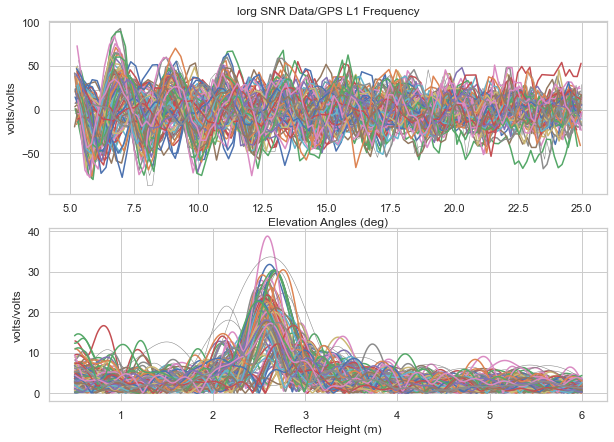

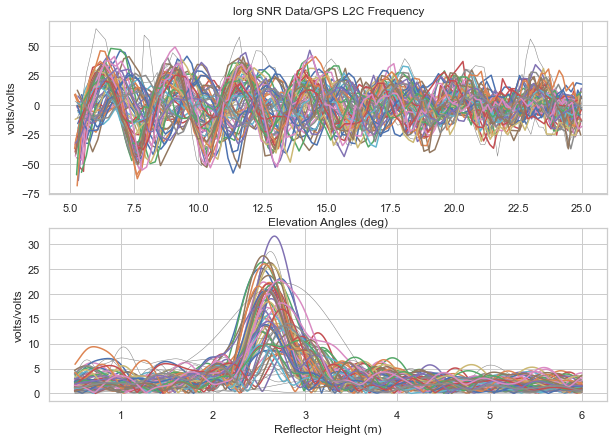

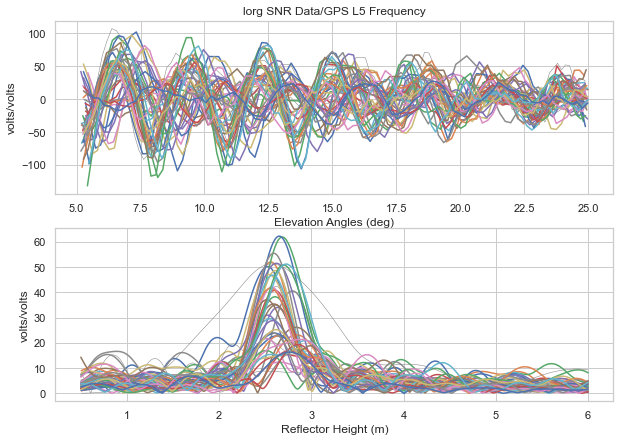

In [15]:
doy = 1
args = check_parameters.gnssir(station, year, doy=1, plt=True, screenstats=False)
year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
print(doy_list)
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

Now we run this for all of the days we downloaded. Note* There will be a lot of 'Could not read the first SNR file'. This is due to the fact that we used the 'weekly' parameter to speed up notebook for this purpose - and it cannot find all of the days we are requesting. 

In [16]:
doy = 1
doy_end=233
args = check_parameters.gnssir(station, year, doy=doy, doy_end=doy_end, screenstats=False)

year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

refraction file exists
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//001.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0010.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//002.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0020.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//003.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0030.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//004.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0040.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//005.txt
Could not r

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//044.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0440.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//045.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0450.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//046.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0460.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//047.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0470.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//048.txt
Could not read the first SN

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//086.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0860.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//087.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0870.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//088.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0880.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//089.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0890.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//090.txt
Could not read the first SN

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//128.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1280.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//129.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1290.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//130.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1300.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//131.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1310.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//132.txt
Could not read the first SN

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//170.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1700.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//171.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1710.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//172.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1720.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//173.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1730.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//174.txt
Could not read the first SN

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//212.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2120.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//213.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2130.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//214.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2140.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//215.txt
Could not read the first SNR file: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2150.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//216.txt
Could not read the first SN

The **daily_avg** command will calculate the daily average reflector height from the daily output files. To minimize outliers in these daily averages, a median filter is set to 0.25 meters and the required minimum number of daily satellite tracks we will set to 50.

In [ ]:
check_parameters.daily_avg?

In [24]:
check_parameters.daily_avg(station, medfilter=.25, ReqTracks=50, plt2screen=False, txtfile='lorg-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/lorg_allRH.txt
Number of files in  2019 35
Daily average RH png file saved as:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/lorg_RH.png
Daily average RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/lorg-dailyavg.txt


This shows the range of reflector heights each day, with each day represented by a different color.

There are also optional inputs for saving a text file of the daily averages. 
The plot is stored at $REFL_CODE/Files/lorg_RH.png 
This is not yet perfect - there are some outliers. 
But it is an excellent example of how easy it is to use the default gnssrefl code to estimate snow accumulation in Antarctica.

In this exercise L1, L2C, and L5 signals were used (i.e. only GPS data). The reflector heights give information 
about snow accumulation at lorg. Notice that when reflector heights are plotted, the y-axis is reversed so that the reflector height gets smaller as the snow layer increases and the distance between the antenna and snow surface decreases.  

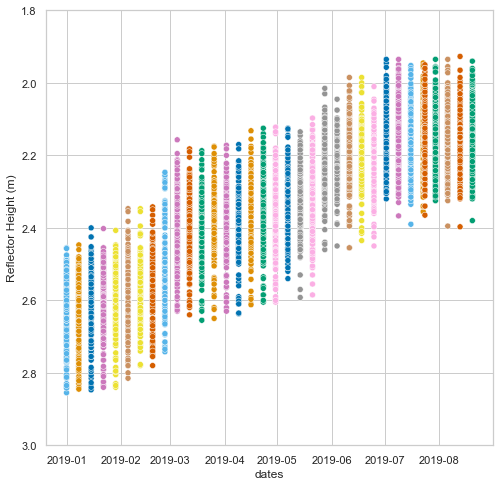

In [32]:
filepath = f'{refl_code_loc}/Files/{station}_allRH.txt'
data = check_parameters.read_allrh_file(filepath)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim(3.0, 1.8)
g.set_ylabel('Reflector Height (m)');

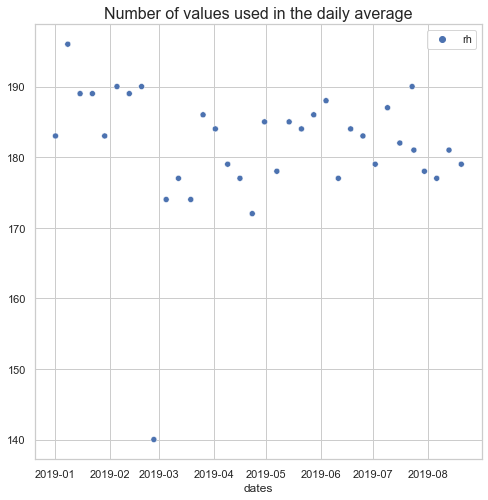

In [26]:
plt.figure(figsize=(8,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

In [27]:
filepath = f'{refl_code_loc}/Files/{station}-dailyavg.txt'
data = check_parameters.read_allrh_file(filepath)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

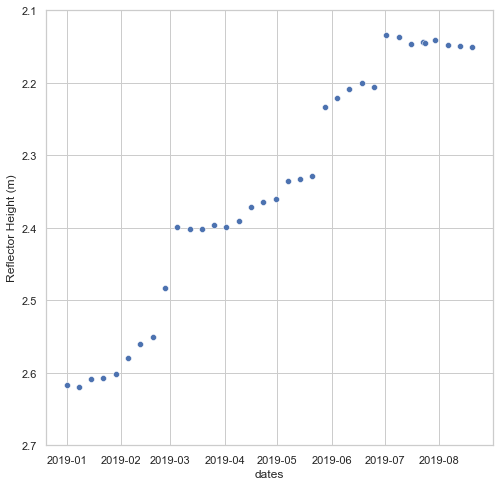

In [30]:
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(2.7,2.1)
g.set_ylabel('Reflector Height (m)');